# Определение возраста покупателей
__________

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-исследования" data-toc-modified-id="Описание-исследования-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание исследования</a></span><ul class="toc-item"><li><span><a href="#Цель-исследования" data-toc-modified-id="Цель-исследования-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Цель исследования</a></span></li><li><span><a href="#Задачи-исследования" data-toc-modified-id="Задачи-исследования-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Задачи исследования</a></span></li><li><span><a href="#Исходные-данные" data-toc-modified-id="Исходные-данные-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Исходные данные</a></span></li></ul></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li></ul></div>

## Описание исследования

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

### Цель исследования
Построить модель, которая по фотографии определит приблизительный возраст человека, взяв в основу набор фотографий людей с указанием возраста.

### Задачи исследования
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитать её качество.

### Исходные данные

В качестве исходных данных имеется набор фотографий людей, а также csv файл с метками (реальным возрастом) и названием соответствующего изображения.

## Исследовательский анализ данных

Импортируем небходимые для работы библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

Выгрузим исходные данные.
Для изображений используем динамическую загрузку данных с помощью `ImageDataGenerator`.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Загрузчик нашел 7591 изображений.

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB



Посмотрим как распределены данные о возрасте клиентов.

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Возраст')

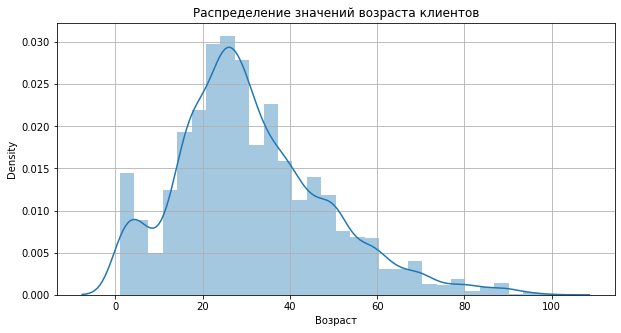

In [12]:
plt.figure(figsize=(10,5))
sns.distplot(labels['real_age'], bins=30)
plt.title('Распределение значений возраста клиентов')
plt.grid()
plt.xlabel('Возраст')

In [7]:
labels['real_age'].describe().loc[['min','25%','50%','75%','max']]

min      1.0
25%     20.0
50%     29.0
75%     41.0
max    100.0
Name: real_age, dtype: float64

Выведем 16 изображений из нашей обучающей выборки.

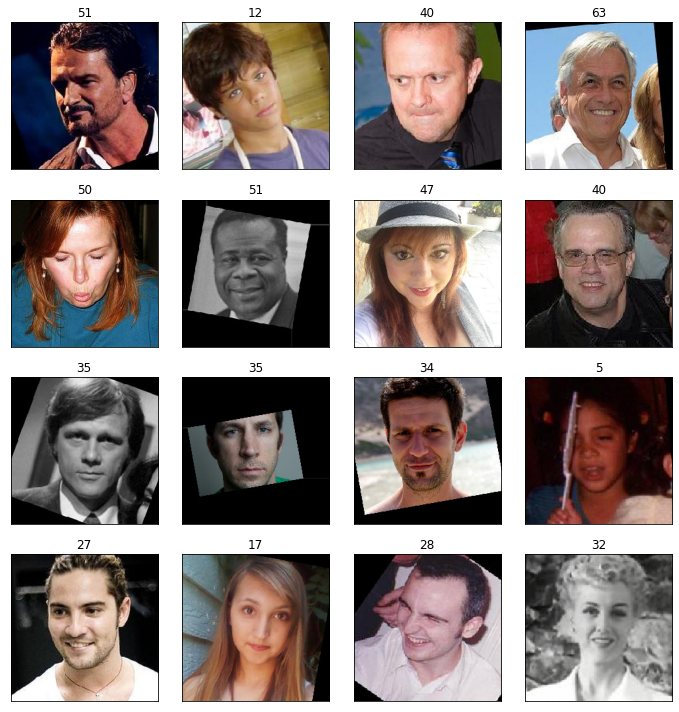

In [13]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод
Получили следующее:

- Всего имеется 7591 изображение с метками о реальном возрасте изображенных на фото людей;
- Возраст варьируется от 1 года до 100 лет. Большинство значений возраста лежит в интервале от 20 лет до 41 года.
- Среди фотографий есть как цветные, так и черно-белые изображения; 
- Люди на изображениях представлены с различными эмоциями (нейтральное выражение лица, радость, грусть и т.д.); 
- В некоторых случаях лицо бывает плохо видно (плохое освещение, часть лица закрыта каким-либо предметом);
- Часть фотографий повернуты под углом менее $90^\circ$.

## Обучение модели

* Использовать будем архитектуру `ResNet50` — это глубокая сеть, которая применяет `skip-connections`, свёртки небольшого размера и `bottleneck-блоки`, так как на большинстве задач она работает лучше других архитектур.

    `Skip-connections` работают лучше, потому что помогают сигналу не затухать при прохождении через очень глубокую сеть. А чем глубже сеть, тем более сложную функцию она может выучить.

    `Bottleneck-блок` позволяет сократить количество весов. Например, на вход модель получает трёхмерный массив с 256 каналами. Вместо пары свёрток с фильтром 3x3, выполним операцию свёртки с фильтром 1x1. Она уменьшит количество каналов в четыре раза — до 64. Затем выполним свёртку 3x3 с сохранением количества каналов. В конце свёрткой 1x1 увеличим количество каналов до 256. «Тяжёлую» свёртку с фильтром 3x3 сделали в тензоре, уменьшенном в четыре раза, то есть сократили и количество обучаемых параметров, и скорость вычислений.

    Чтобы адаптировать `ResNet50` к нашей задаче, уберём верхушку и сконструируем её заново - «заморозим» часть сети: некоторые слои оставим с весами из `ImageNet`, они не будут обучаться градиентным спуском. Обучим только 1–2 полносвязных слоя наверху сети. 
________


* Чтобы подбор шага был автоматическим, применим алгоритм `Adam`. Он подбирает различные параметры для разных нейронов, что также ускоряет обучение модели.

* Шаг градиентного спуска, с которого алгоритм стартует (learning rate) выберем равным 0.0001.

* Если обучающих примеров мало, сеть может переобучиться. Чтобы увеличить датасет, применим также аугментацию - преобразуем исходные изображения (отразим фото по горизонтали) с сохранением его целевого признака. 
* Количество эпох выберем небольшое-5.

Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

```
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-06-02 12:52:51.375943: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-06-02 12:52:51.679424: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 46s - loss: 206.9476 - mae: 10.4477 - val_loss: 500.3801 - val_mae: 17.2281
Epoch 2/5
356/356 - 37s - loss: 85.1035 - mae: 6.9687 - val_loss: 141.1109 - val_mae: 9.0063
Epoch 3/5
356/356 - 37s - loss: 60.1411 - mae: 5.9097 - val_loss: 88.3771 - val_mae: 7.2788
Epoch 4/5
356/356 - 37s - loss: 44.8817 - mae: 5.0707 - val_loss: 76.1520 - val_mae: 6.5629
Epoch 5/5
356/356 - 37s - loss: 32.6527 - mae: 4.4017 - val_loss: 70.0197 - val_mae: 6.3470

119/119 - 9s - loss: 70.0197 - mae: 6.3470
Test MAE: 6.3470

```

## Анализ обученной модели

В результате обучения модели получили, что в среднем модель ошибается чуть более чем на 6 лет (MAE = 6.3470). На обучающей выборке это значение чуть меньше - MAE = 4.4017.

Для решения ранее поставленной задачи, а именно выделения возрастных групп клиентов с целью анализа их покупок и предложения им определенных товаров, которые могут их заинтересовать, модель подходит - разница в 6 лет не кажется тут значительной, а соседние возрастные категории скорее всего характеризуются похожими категориями покупаемых товаров.

Если же упор делать на задачу контроля добросовестности кассиров при продаже алкоголя, большее значение имеет точность предсказания для возрастных групп 18±7 лет. Поэтому можно предложить дополнить выборку изображениями людей возрастом в этом диапазоне.